<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Requisição-da-Imagem-através-da-URL" data-toc-modified-id="Requisição-da-Imagem-através-da-URL-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Requisição da Imagem através da URL</a></span></li><li><span><a href="#Extraindo-Imagens-de-Jogadores" data-toc-modified-id="Extraindo-Imagens-de-Jogadores-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Extraindo Imagens de Jogadores</a></span></li><li><span><a href="#Encapsulando-o-Código" data-toc-modified-id="Encapsulando-o-Código-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Encapsulando o Código</a></span></li></ul></div>

Este notebook tem o objetivo de documentar os esforços relacionados ao download de imagens de jogadores ativos da NBA para uma posterior inserção em paineis e dashboards. Em uma primeira busca, foi verificaro que a biblioteca python `nba_api` não possui nenhum endpoint nativo para a extração de imagens o que, dessa forma, exigiu uma pesquisa mais refinada sobre as possibilidades de realizar essa extração.

Nos blocos a seguir, serão detalhadas as tentativas realizadas a partir da biblioteca `requests` do Python considerando, como entrada da requisição, o endpoint da imagem armazenada retirada diretamente do site de estatísticas da NBA.

<div align="center">
    <br><img src="https://i.imgur.com/l07Xn2Y.png" height=600 width=400 alt="nbaflow logo">
</div>

# Requisição da Imagem através da URL

Como informado anteriormente, nesta sessão será proposta a extração pontual de imagens utilizando o endpoint original de armazenamento das imagens localizadas no site de estatísticas da NBA. Para ilustrar melhor essa situação, a url https://www.nba.com/stats/player/203507/ leva a uma página geral de estatísticas do jogador Giannis Antetokounmpo (*player_id=203507*) e, no header da página, é possível visualizar uma imagem vetorizada do próprio jogador. O objetivo deste material é propor técnicas automatizadas para extração dessa imagem vetorizada, permitindo assim inserções dinâmicas em frentes relacionadas a criação de dashboards.

<div align="center">
    <br><img src="https://i.imgur.com/q5nyVqq.png" height=800 width=900 alt="giannis header">
</div>


Ao copiar exatamente o local da imagem posicionada nesse header, é possível verificar o endpoint relacionado com a seguinte url:

    https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/1610612749/2020/260x190/203507.png
    
Dessa forma, uma tentativa válida seria realizar uma requisição em Python considerando essa url e, posteriormente, salvar o resultado (provavelmente um blob) em uma imagem ong no sistema de arquivos do SO.

In [12]:
# Importando requests
import requests

# Preparando requisição
url = 'https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/1610612749/2020/260x190/203507.png'

r = requests.get(url)
print(f'Primeiros elementos do conteúdo retornado:')
print(r.content[:15])

Primeiros elementos do conteúdo retornado:
b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD'


Apesar de aparentemente ilegível, o conteúdo retornado pela requisição proposta equivale a uma imagem. Para validar esse entendimento, será proposta a utilização dos pacotes `PIL` e `urllib` para utilizar a url salva para o jogador Giannis Antetokounmpo e plotar a imagem retornada na tela.

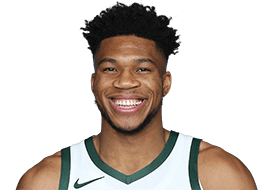

In [26]:
# Importando bibliotecas
from PIL import Image
import urllib

# Plotando imagem do jogador através da url salva
Image.open(urllib.request.urlopen(url))

Ótimo! Nesse formato de trabalho, utilizou-se uma url do jogador com um prefixo aparentemente padrão, tendo como margem de alteração apenas o id do jogador segundo o site oficial de estatísticas da NBA. Contando com essas premissas, seria possível então construir um código capaz de iterar por uma base de jogadores ativos e retornar todas as imagens de cada um deles. Antes de implementar esse bloco de código, é importante definir como essas imagens retornadas serão armazenadas no diretório local do sistema operacional. Para tal, o código abaixo realiza a criação de um arquivo png para o jogador em questão e salva o conteúdo da requisição neste objeto que, por sua vez, será salvo nos sistema operacional para resgate futuro.

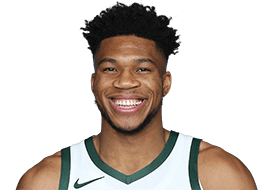

In [28]:
# Criando arquivo png para armazenar conteúdo da imagem
with open('../images/player_giannis_antetokounmpo.png', 'wb') as f:
    f.write(r.content)
    
# Testando escrita do arquivo
Image.open('../images/player_giannis_antetokounmpo.png')

# Extraindo Imagens de Jogadores

Como primeiro passo, é importante extrair uma lista de todos os jogadores as quais serão extraídas as imagens e salvas em diretório local. Para isso, será utilizado o módulo estático da biblioteca `nba_api` para retornar dados de jogadores e de times.

Ao analisar em mais detalhes a url de retorno de imagem de atletas, nota-se que dois dos principais parâmetros de configuração são relacionados ao *id do time* e ao *id do jogador*. Observando novamente a url do jogador Giannis Antetokounmpo, percebe-se:

    URL: https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/1610612749/2020/260x190/203507.png
    Id Milwaukee Bucks: 1610612749
    Id Giannis Antetokounmpo: 203507
    
Dessa forma, para formar uma string de requisição para cada jogador ativo da base, é preciso relacionar as informações do id do jogador e também do id do time a qual o mesmo defende.

In [84]:
# Importando bibliotecas
import pandas as pd
pd.set_option('display.max_columns', 500)
from nba_api.stats.static import players

# Lista de todos os jogadores ativos
active_players = pd.DataFrame(players.get_active_players())
print(f'Jogadores ativos: {len(active_players)}')
active_players.head()

Jogadores ativos: 519


,id,full_name,first_name,last_name,is_active
0,203500,Steven Adams,Steven,Adams,True
1,1628389,Bam Adebayo,Bam,Adebayo,True
2,200746,LaMarcus Aldridge,LaMarcus,Aldridge,True
3,1629734,Kyle Alexander,Kyle,Alexander,True
4,1629638,Nickeil Alexander-Walker,Nickeil,Alexander-Walker,True


Apesar de fornecer uma resposta rápida e extremamente direta, o módulo `players` da biblioteca `nba_api` não retorna as informações relacionadas aos times de cada um dos jogadores, dificultando assim o levantamento das premissas para a realização das requisições das imagens. Dessa forma, uma outra alternativa se faz presente a partir do módulo `commonallplayers` da mesma biblioteca.

O tradeoff dessa alteração é que, por se tratar de um *endpoint* da biblioteca, a consulta acima está sujeita a erros de timeout o que, de fato, precisará ser tratado em um encapsulamento futuro.

In [133]:
# Retornando informações completas de jogadores via endpoint commonallplayers
from nba_api.stats.endpoints import commonallplayers

# Resultado da requisição
players_info = commonallplayers.CommonAllPlayers().common_all_players.get_data_frame()
print(f'Total de registros de jogadores retornados: {len(players_info)}')
players_info.head()

ReadTimeout: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)

Observando a base resultante, é possível perceber, em primeiro lugar, que a mesma aparentemente aloca todos os jogadores que já jogaram na NBA em algum momento. Considerando os aproximadamente 500 jogadores ativos retornados a partir do módulo estático de jogadores, será necessário, nessa segunda abordagem, aplicar alguns filtros úteis para retornar apenas os jogadores alvo de análise.

Outro ponto importante que merece destaque é a presença de informações relevantes para o objetivo desse material: nessa segunda abordagem, a base resultante contém minimamente o id do jogador e do seu respectivo time. Assim, o bloco de código abaixo terá como objetivo filtrar os jogadores ativos alvo de análise e também selecionar apenas as colunas úteis para a posterior requisição de imagens.

In [120]:
# Importando bibliotecas
from datetime import datetime

# Filtrando jogadores alvo: ativos até a temporada atual com vínculo em algum time
current_year = str(datetime.now().year - 1)
target_players = players_info.query('TO_YEAR == @current_year and TEAM_ID > 0')

# Filtrando colunas
target_players = target_players.loc[:, ['PERSON_ID', 'DISPLAY_FIRST_LAST', 'PLAYER_SLUG', 'TEAM_ID']]
target_players.columns = ['player_id', 'player_name', 'player_name_code', 'team_id']
print(f'Quantidade de jogadores alvo: {len(target_players)}')
target_players.reset_index(drop=True, inplace=True)
target_players.head()

Quantidade de jogadores alvo: 503


,player_id,player_name,player_name_code,team_id
0,1630173,Precious Achiuwa,precious_achiuwa,1610612748
1,203500,Steven Adams,steven_adams,1610612740
2,1628389,Bam Adebayo,bam_adebayo,1610612748
3,1630234,Ty-Shon Alexander,ty-shon_alexander,1610612756
4,1629638,Nickeil Alexander-Walker,nickeil_alexander-walker,1610612740


Com esses dados em mãos, visando facilitar o trabalho a ser realizado em um posterior laço de repetição, será proposta a criação de novas colunas na base de jogadores ativos contendo as urls necessárias para as requisições.

In [121]:
# Incrementando url de requisição
static_url = 'https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/team_id/2020/260x190/player_id'
img_format = '.png'
target_players['img_url'] = target_players.apply(lambda x: static_url.replace('team_id', str(x['team_id'])).replace('player_id', str(x['player_id'])) + img_format, axis=1)

# Gerando referência de arquivo a ser salvo
target_players['player_name_img'] = target_players['player_name_code'] + img_format

# Testando resultado
dame_url = target_players.query('player_name == "Damian Lillard"')['img_url'].values[0]
print(f'[TESTE] String de requisição para o jogador Damian Lillard:\n{dame_url}')

target_players.head()

[TESTE] String de requisição para o jogador Damian Lillard:
https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/1610612757/2020/260x190/203081.png


,player_id,player_name,player_name_code,team_id,img_url,player_name_img
0,1630173,Precious Achiuwa,precious_achiuwa,1610612748,https://ak-static.cms.nba.com/wp-content/uploa...,precious_achiuwa.png
1,203500,Steven Adams,steven_adams,1610612740,https://ak-static.cms.nba.com/wp-content/uploa...,steven_adams.png
2,1628389,Bam Adebayo,bam_adebayo,1610612748,https://ak-static.cms.nba.com/wp-content/uploa...,bam_adebayo.png
3,1630234,Ty-Shon Alexander,ty-shon_alexander,1610612756,https://ak-static.cms.nba.com/wp-content/uploa...,ty-shon_alexander.png
4,1629638,Nickeil Alexander-Walker,nickeil_alexander-walker,1610612740,https://ak-static.cms.nba.com/wp-content/uploa...,nickeil_alexander-walker.png


In [122]:
# Iterando sobre a base completa
for index, row in target_players.iterrows():
    img = requests.get(row['img_url'])
    with open(f'../images/{row["player_name_img"]}', 'wb') as f:
        f.write(img.content)

In [137]:
# Observando resultado
import os
images = os.listdir('../images')
print(f'Quantidade de imagens salvas: {len(images)}')
print(f'\nPrimeiros arquivos de exemplo: \n{images[:5]}')

Quantidade de imagens salvas: 503

Primeiros arquivos de exemplo: 
['aaron_gordon.png', 'aaron_holiday.png', 'aaron_nesmith.png', 'abdel_nader.png', 'adam_mokoka.png']


Sucesso! Com o código desenvolvido foi possível requisitar as imagens de todos os atletas da NBA de acordo com o alvo de análise, salvando assim os respectivos arquivos em um diretório local. Entretanto, ao observar o conteúdo dos arquivos localmente, percebe-se que alguns deles não foram retornados com sucesso o que, de fato, pode ser considerado como um ponto adicional de incremento na lógica de requisição das imagens. 

# Encapsulando o Código

Uma vez exploradas as possibilidades de extração de imagens de jogadores de forma dinâmica, é possível definir uma função única capaz de consolidar todos os conhecimentos e lógicas de validação adquiridos até o momento, proporcionando assim uma maior facilidade ao usuário final consumidor das informações.

In [1]:
# Importando bibliotecas
from nba_api.stats.endpoints import commonallplayers
import requests
import pandas as pd
from datetime import datetime
import logging
import os
import shutil

# Definindo parâmetros de consulta e de filtros
STATIC_IMG_URL = 'https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/team_id/2020/260x190/player_id'

# Definindo função para configurar objeto de log do código
def log_config(logger, level=logging.DEBUG, 
               log_format='%(levelname)s;%(asctime)s;%(filename)s;%(module)s;%(lineno)d;%(message)s',
               log_filepath=os.path.join(os.getcwd(), 'exec_log/execution_log.log'),
               flag_file_handler=False, flag_stream_handler=True, filemode='a'):
    """
    Função que recebe um objeto logging e aplica configurações básicas ao mesmo
    
    Parâmetros
    ----------
    :param logger: objeto logger criado no escopo do módulo [type: logging.getLogger()]
    :param level: level do objeto logger criado [type: level, default=logging.DEBUG]
    :param log_format: formato do log a ser armazenado [type: string]
    :param log_filepath: caminho onde o arquivo .log será armazenado 
        [type: string, default='exec_log/execution_log.log']
    :param flag_file_handler: define se será criado um arquivo de armazenamento de log
        [type: bool, default=False]
    :param flag_stream_handler: define se as mensagens de log serão mostradas na tela
        [type: bool, default=True]
    :param filemode: tipo de escrita no arquivo de log [type: string, default='a' (append)]
    
    Retorno
    -------
    :return logger: objeto logger pré-configurado
    """

    # Setting level for the logger object
    logger.setLevel(level)

    # Creating a formatter
    formatter = logging.Formatter(log_format, datefmt='%Y-%m-%d %H:%M:%S')

    # Creating handlers
    if flag_file_handler:
        log_path = '/'.join(log_filepath.split('/')[:-1])
        if not isdir(log_path):
            makedirs(log_path)

        # Adding file_handler
        file_handler = logging.FileHandler(log_filepath, mode=filemode, encoding='utf-8')
        file_handler.setFormatter(formatter)
        logger.addHandler(file_handler)

    if flag_stream_handler:
        # Adding stream_handler
        stream_handler = logging.StreamHandler()
        stream_handler.setFormatter(formatter)    
        logger.addHandler(stream_handler)

    return logger

# Instanciando e configurando objeto de log
logger = logging.getLogger('nbaflow-images')
logger = log_config(logger)

In [5]:
# Definindo função para coleta de informações detalhadas de jogadores alvo
def get_players_info(timeout=30, error_strategy='infinity', **kwargs):
    """
    Utiliza o endpoint commonallplayers da biblioteca nba_api para
    providenciar informações detalhadas de todos os jogadores da
    NBA (ativos e aposentados). Em seu background, essa implementação
    realiza consultas diretamente à API e, portanto, pontos de
    reprocessamentos de requisição foram adicionados para garantir
    o retorno da informação de acordo com uma estratégia de erro
    definida pelo usuário. Assim, é possível configurar a função
    para realizar tentativas infinitamente até que o dado seja
    retornado ou então por um número finito de tentativas.

    Parâmetros
    ----------
    :param timeout:
            Limite de tempo, em segundos, a ser considerado para
            cada requisição.
            [type: int, default=30]

    :param error_strategy:
        Define o tipo de estratégia a ser utilizada no reprocessamento
        das requisições com falhas.

        *strategy='infinity': as tentativas de reprocessamento são
        realizadas até que o sucesso completo seja obtido. Uma
        observação plausível a ser feita é que, nesse modo, a 
        execução do código pode demorar de forma incalculável.

        *strategy='attempts': é definido um limite de tentativas
        de reprocessamento dos dados. Nessa abordagem, evita-se que
        o codigo demande tempos elevados de execução, porém não
        há a garantia que todos os dados serão retornados para
        todos os jogadores.

        [type: string, default='infinity']
        
    **kwargs
    --------
    :arg error_verbose:
        Tentaivas necessárias até que se tenha uma comunicação
        com o usuário via logger.
        [type: int, default=5]
    
    :arg num_attempts:
        Número de tentativas de reprocessamento em caso de 
        error_strategy='attempts'. Ao final de cada tentativa,
        a base de erros é atualizada e verificada. Em caso de
        sucesso, a execução é interrompida. Caso as tentativas
        se esgotem e ainda existam errors, os dados faltantes
        são desconsiderados do retorno final.
        [type: int, default=11]

    :arg timeout_increase:
        Número inteiro utilizado para incrementar o timeout da
        requisição a cada tentativa, propondo assim uma maior
        tolerância e uma maior chance de retorno dos dados a 
        cada nova requisição.
        [type: int, default=5]
    
    :arg current_year:
        Referência do ano de início da temporada atual da NBA
        para aplicação de filtro em base geral de jogadores.
        O objetivo deste parâmetro é servir como filtro de
        retorno para jogadores ativos, ou seja, jogadores
        que jogaram até a referência current_year
        [type: string, default=str(datetime.now().year - 1)]
        
    Retorno
    -------
    :return players_info:
        Base de dados com informações detalhadas de jogadores
        da NBA.
        [type: pd.DataFrame]
    """
    
    # Variáveis de controle
    i = 1
    error_verbose = kwargs['error_verbose'] if 'error_verbose' in kwargs else 5
    timeout_increase = kwargs['timeout_increase'] if 'timeout_increase' in kwargs else 5
    logger.debug(f'Extraindo base com informações detalhadas de jogadores da NBA')
    
    # Iniciando laço infinito de tentativas
    if error_strategy == 'infinity':
        while True:          
            try:
                players_info = commonallplayers.CommonAllPlayers(timeout=timeout).common_all_players.get_data_frame()             
                break
            except Exception as e:
                # Comunicando usuário sobre tentativas
                if i % error_verbose == 0:
                    logger.warning(f'{i}° timeout na requisição de informações de jogadores. Iniciando tentativa número {i+1}')
                i += 1
                
                # Incrementando timeout para próxima requisição
                timeout += timeout_increase
                continue
    
    # Iniciando laço finito de tentativas de retorno
    elif error_strategy == 'attempts':
        num_attempts = kwargs['num_attempts'] if 'num_attempts' in kwargs else 11
        success_flag = 0
        for j in range(num_attempts):
            try:
                players_info = commonallplayers.CommonAllPlayers(timeout=timeout).common_all_players.get_data_frame()
                success_flag = 1
                break
            except Exception as e:
                # Incrementando timeout para próxima requisição
                timeout += timeout_increase
                
                # Comunicando usuário sobre tentativas
                if i % error_verbose == 0:
                    logger.warning(f'{i}° timeout na requisição de informações de jogadores. Iniciando tentativa número {i+1} com timeout igual a {timeout}')
                i += 1
                
                continue
                
        if success_flag == 0:
            logger.error(f'Tentativas esgotadas sem sucesso no retorno das informações. Tente aumentar o parâmetro "num_attempts" ou mudar o parâmetro "error_strategy" para "infinity"')
            return
    
    # Argumento error_strategy incorreto
    else:
        logger.error(f'Estratégia de reprocessamento inválida. Selecione entre "infinity" ou "attempts"')
        return
    
    # Aplicando formatações e filtros na base de jogadores extraída
    current_year = kwargs['current_year'] if 'current_year' in kwargs else str(datetime.now().year - 1)
    players_info = players_info.query('TO_YEAR == @current_year and TEAM_ID > 0')
    
    # Filtrando colunas e dropando index
    players_info = players_info.loc[:, ['PERSON_ID', 'DISPLAY_FIRST_LAST', 'PLAYER_SLUG', 'TEAM_ID']]
    players_info.columns = ['player_id', 'player_name', 'player_name_code', 'team_id']
    players_info.reset_index(drop=True, inplace=True)
    
    return players_info

# Definindo função para extração e salvamento local de imagens de jogadores
def get_players_images(static_url, img_format='.png', team_id_col='team_id', player_id_col='player_id',
                       player_name_code_col='player_name_code', imgs_path='../data/images/', timeout=30, 
                       assign_template_img=True, template_img_path=os.path.join(os.getcwd(), 'template_img.png'),
                       **kwargs):
    
    """
    Realiza a extração de uma base de jogadores alvo que tiveram
    partidas registradas até a temporada atual e utiliza informações
    chave dessa base (como id do jogador e id do time) para montar
    uma string de requisição responsável por extrair imagens de
    cada um dos jogadores. Essa função executa a função
    get_players_info() para coletar a base de jogadores alvo e
    utiliza o módulo requests para requisitar e salvar o conteúdo
    das imagens originalmente disponíveis na url do site oficial
    de estatísticas da NBA.

    Parâmetros
    ----------
    :param static_url:
        Template estático de url de captura das imagens disponível
        no site oficial de estatísticas da NBA. No estado atual
        de construção dessa função, o template de url tem o formato
        "https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/team_id/2020/260x190/player_id",
        sendo de responsabilidade do código aqui encapsulado
        substituir os parâmetros "team_id" e "player_id" da url
        de requisição de modo a extrair corretamente as imagens
        requisitadas.
        
    :param img_format:
        Formato da imagem a ser salva localmente em diretório local
        do sistema operacional de uso.
        [type: string, default='.png']
        
    :param team_id_col:
        Referência de coluna contendo o id do time para substituição
        no template estático de url. Essa informação é extraída
        da base gerada pela função get_players_info().
        [type: string, default='team_id']
        
    :param player_id_col:
        Referência de coluna contendo o id do jogador para substituição
        no template estático de url. Essa informação é extraída
        da base gerada pela função get_players_info().
        [type: string, default='player_id']
        
    :param player_name_code_col:
        Referência de coluna contendo o nome tratado do jogador
        para posterior salvamento de arquivo com referência
        exclusiva ao jogador em questão. Essa informação é extraída
        da base gerada pela função get_players_info().
        [type: string, default='player_name_code']
        
    :param imgs_path:
        Referência de diretório local alvo de salvamento das imagens
        requisitadas. Como observação, é válido citar que, em caso
        de inexistência do diretório, a função irá criar um com
        a referência contida neste parâmetro.
        [type: string, default='../images/']
    
    :param timeout:
        Limite de tempo, em segundos, a ser considerado para
        cada requisição.
        [type: int, default=30]
            
    :param assign_template_img:
        Define a designação de um template padrão para o jogador
        caso sua imagem não seja encontrada no site (código de 
        retorno da requisição diferente de 200). A imagem
        template considera uma "sombra" genérica de um jogador
        contendo uma interrogação ("?") no centro. Caso este
        flag seja configurado como True, essa foto genérica
        será salva com o nome do jogador cujo código retorno
        da requisição obtido ser diferente de 200.
        [type: bool, default=True]
        
    :param template_img_path:
        Define o caminho padrão de armazenamento da imagem de
        template a ser utilizada em casos de erros na requisição.
        Ao validar o sucesso do código de retorno da requisição,
        esse parâmetro é utilizado para buscar, ler e salvar
        uma nova imagem para o jogador em questão.
        [type: string, default=os.path.join(os.getcwd(), 'template_img.png']
    
    **kwargs
    --------
    :arg error_strategy:
        Define o tipo de estratégia a ser utilizada no reprocessamento
        das requisições com falhas.

        *strategy='infinity': as tentativas de reprocessamento são
        realizadas até que o sucesso completo seja obtido. Uma
        observação plausível a ser feita é que, nesse modo, a 
        execução do código pode demorar de forma incalculável.

        *strategy='attempts': é definido um limite de tentativas
        de reprocessamento dos dados. Nessa abordagem, evita-se que
        o codigo demande tempos elevados de execução, porém não
        há a garantia que todos os dados serão retornados para
        todos os jogadores.

        [type: string, default='infinity']
        
    :arg error_verbose:
        Tentaivas necessárias até que se tenha uma comunicação
        com o usuário via logger.
        [type: int, default=5]
    
    :arg num_attempts:
        Número de tentativas de reprocessamento em caso de 
        error_strategy='attempts'. Ao final de cada tentativa,
        a base de erros é atualizada e verificada. Em caso de
        sucesso, a execução é interrompida. Caso as tentativas
        se esgotem e ainda existam errors, os dados faltantes
        são desconsiderados do retorno final.
        [type: int, default=11]

    :arg timeout_increase:
        Número inteiro utilizado para incrementar o timeout da
        requisição a cada tentativa, propondo assim uma maior
        tolerância e uma maior chance de retorno dos dados a 
        cada nova requisição.
        [type: int, default=5]
    
    :arg current_year:
        Referência do ano de início da temporada atual da NBA
        para aplicação de filtro em base geral de jogadores.
        O objetivo deste parâmetro é servir como filtro de
        retorno para jogadores ativos, ou seja, jogadores
        que jogaram até a referência current_year
        [type: string, default=str(datetime.now().year - 1)]
        
    Retorno
    -------
    :return success_requests:
        Base de dados com informações detalhadas de jogadores
        cuja requisição de imagens foi obtida com sucesso.
        [type: pd.DataFrame]
        
    :return fail_requests:
        Base de dados com informações detalhadas de jogadores
        cuja requisição de imagens foi obtida com falha.
        [type: pd.DataFrame]
    """
    
    # Extraindo argumentos adicionais para retorno de base alvo de jogadores
    error_strategy = kwargs['error_strategy'] if 'error_strategy' in kwargs else 'infinity'
    error_verbose = kwargs['error_verbose'] if 'error_verbose' in kwargs else 5
    timeout_increase = kwargs['timeout_increase'] if 'timeout_increase' in kwargs else 5
    num_attempts = kwargs['num_attempts'] if 'num_attempts' in kwargs else 11
    current_year = kwargs['current_year'] if 'current_year' in kwargs else str(datetime.now().year - 1)
    
    # Coletando base de jogadores alvo
    target_players = get_players_info(timeout=timeout, error_strategy=error_strategy, error_verbose=error_verbose,
                                      timeout_increase=timeout_increase, num_attempts=num_attempts, 
                                      current_year=current_year)   
    if target_players is None:
        return None, None
    
    # Criando coluna com a url de pesquisa para cada jogador
    target_players['img_url'] = target_players.apply(lambda x: static_url.replace('team_id', str(x[team_id_col])).replace('player_id', str(x[player_id_col])) + img_format, axis=1)
    
    # Gerando referência de arquivo a ser salvo
    target_players['player_name_img'] = target_players[player_name_code_col].astype(str) + img_format
    
    # Definindo parâmetros de controle
    success, errors, i = 0, 0, 0
    fail_requests = []
    success_requests = []
    
    # Iterando sobre base de dados com informações de jogadores
    logger.debug(f'Iniciando extração de imagens para jogadores da NBA')
    for index, row in target_players.iterrows():
        
        # Requisitando imagem
        i += 1
        img = requests.get(row['img_url'], timeout=timeout)
        if img.status_code != 200:
            errors += 1
            fail_requests.append(row)
            
            # Copiando imagem template com nome do jogador
            if assign_template_img:
                shutil.copy(src=template_img_path, dst=imgs_path + row["player_name_img"])
                
            continue

        # Salvando imagem em diretório local
        try:
            with open(f'{imgs_path + row["player_name_img"]}', 'wb') as f:
                f.write(img.content)
        except FileNotFoundError as fe:
            # Diretório não existente. Criando um e salvando arquivo
            os.makedirs(imgs_path)
            with open(f'{imgs_path + row["player_name_img"]}', 'wb') as f:
                f.write(img.content)

        # Comunicando usuário
        success += 1
        success_requests.append(row)
        if i % 50 == 0:
            logger.debug(f'{i} requisições realizadas, sendo {success} com sucesso e {errors} com falhas')
    
    logger.info(f'Processo encerrado com {i} requisições, sendo {success} com sucesso e {errors} com falhas')
    return pd.DataFrame(success_requests), pd.DataFrame(fail_requests)


In [6]:
# Salvando imagens de jogadores
success_requests, fail_requests = get_players_images(static_url=STATIC_IMG_URL, player_name_code_col='player_id',
                                                     template_img_path='../data/unknown_player_template.png')

DEBUG;2021-07-16 21:48:17;3274266222.py;3274266222;81;Extraindo base com informações detalhadas de jogadores da NBA
DEBUG;2021-07-16 21:48:17;3274266222.py;3274266222;310;Iniciando extração de imagens para jogadores da NBA
DEBUG;2021-07-16 21:48:22;3274266222.py;3274266222;340;50 requisições realizadas, sendo 47 com sucesso e 3 com falhas
DEBUG;2021-07-16 21:48:28;3274266222.py;3274266222;340;100 requisições realizadas, sendo 88 com sucesso e 12 com falhas
DEBUG;2021-07-16 21:48:37;3274266222.py;3274266222;340;200 requisições realizadas, sendo 181 com sucesso e 19 com falhas
DEBUG;2021-07-16 21:48:48;3274266222.py;3274266222;340;300 requisições realizadas, sendo 269 com sucesso e 31 com falhas
DEBUG;2021-07-16 21:48:53;3274266222.py;3274266222;340;350 requisições realizadas, sendo 315 com sucesso e 35 com falhas
DEBUG;2021-07-16 21:48:59;3274266222.py;3274266222;340;400 requisições realizadas, sendo 357 com sucesso e 43 com falhas
DEBUG;2021-07-16 21:49:06;3274266222.py;3274266222;340;

In [10]:
# Deletando imagens baixadas de jogadores não presentes na base
gamelog = pd.read_csv('../data/all_players_gamelog.csv')
players = sorted(gamelog['player_id'].unique())
players_imgs = os.listdir('../data/images')

print(f'Jogadores únicos na base de gamelog: {len(players)}')
print(f'Imagens totais baixadas: {len(players_imgs)}')

Jogadores únicos na base de gamelog: 417
Imagens totais baixadas: 503


In [8]:
# Iterando sobre as imagens baixadas
for img in players_imgs:
    img_split = img[:-4]
    print(img_split)

101108
101141
101150
1626143
1626145
1626149
1626153
1626156
1626157
1626158
1626159
1626161
1626162
1626163
1626164
1626166
1626167
1626168
1626169
1626171
1626172
1626174
1626178
1626179
1626181
1626184
1626192
1626195
1626196
1626204
1626220
1626224
1626245
1626246
1626253
1627732
1627734
1627736
1627739
1627741
1627742
1627745
1627747
1627749
1627750
1627751
1627752
1627756
1627759
1627761
1627763
1627774
1627777
1627780
1627783
1627788
1627789
1627812
1627814
1627823
1627826
1627827
1627832
1627846
1627853
1627854
1627863
1627884
1627885
1627936
1628021
1628035
1628365
1628366
1628367
1628368
1628369
1628370
1628371
1628372
1628373
1628374
1628378
1628379
1628380
1628381
1628382
1628384
1628385
1628386
1628388
1628389
1628391
1628392
1628395
1628396
1628398
1628400
1628401
1628402
1628404
1628407
1628408
1628410
1628411
1628414
1628415
1628418
1628420
1628422
1628425
1628427
1628436
1628449
1628455
1628464
1628467
1628470
1628539
1628578
1628778
1628960
1628961
1628962
1628963
162

In [12]:
101108 in players

True

In [14]:
img_split

'2772'

In [15]:
# Iterando sobre as imagens baixadas
for img in players_imgs:
    img_split = img[:-4]
    if int(img_split) not in players:
        # Removendo imagem caso jogador inexistente na base
        #os.remove(f'../data/images/{img}')
        print(img_split)
        
# Verificando números finais
print(f'Total de imagens após a remoção: {len(os.listdir("../data/images"))}')

1628578
1628962
1629007
1629091
1629603
1629604
1629617
1629643
1629653
1629670
1629681
1629685
1629686
1629712
1629717
1629833
1630162
1630163
1630164
1630165
1630166
1630167
1630168
1630169
1630170
1630171
1630172
1630173
1630174
1630175
1630176
1630177
1630178
1630179
1630180
1630181
1630182
1630183
1630184
1630185
1630186
1630187
1630188
1630189
1630190
1630191
1630192
1630193
1630194
1630197
1630198
1630199
1630200
1630201
1630202
1630203
1630205
1630206
1630207
1630208
1630209
1630210
1630214
1630216
1630217
1630218
1630219
1630221
1630230
1630231
1630233
1630234
1630235
1630237
1630240
1630241
1630253
1630256
1630258
1630264
1630267
1630268
1630271
1630273
1630466
1630492
Total de imagens após a remoção: 503
